In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0664.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/1269.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0733.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0106.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0375.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/1075.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0285.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0591.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0799.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/1411.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0074.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/1031.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0077.jpg

In [2]:
! pip install split_folders

In [3]:
import os
import shutil
import splitfolders
import tensorflow as tf
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32")
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense,Activation,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential

from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import itertools

import matplotlib.pyplot as plt
import datetime
import matplotlib.image as mping
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


2024-05-22 17:32:53.310752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 17:32:53.310846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 17:32:53.453120: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from tensorflow.keras.applications import VGG19, Xception

In [5]:
# Path to the consolidated data
loc = "/kaggle/input/autism-image-data/AutismDataset/consolidated"

In [6]:
# Create output directories
os.makedirs('output', exist_ok=True)
os.makedirs('output/train', exist_ok=True)
os.makedirs('output/val', exist_ok=True)
os.makedirs('output/test', exist_ok=True)

In [7]:
# Split data into training, validation, and test sets
splitfolders.ratio(loc, output="output", seed=0, ratio=(0.80, 0.1, 0.1))

Copying files: 2940 files [00:24, 118.05 files/s]


In [8]:
# Load data
train_dir = "output/train"
test_dir = "output/test"
val_dir = "output/val"

In [9]:
train_data = image_dataset_from_directory(train_dir, batch_size=32, image_size=(224, 224), label_mode='categorical', shuffle=True, seed=0)
test_data = image_dataset_from_directory(test_dir, batch_size=32, image_size=(224, 224), label_mode='categorical', shuffle=False, seed=0)
val_data = image_dataset_from_directory(val_dir, batch_size=32, image_size=(224, 224), label_mode='categorical', shuffle=False, seed=0)

Found 2352 files belonging to 2 classes.
Found 294 files belonging to 2 classes.
Found 294 files belonging to 2 classes.


In [10]:
class_names = train_data.class_names
class_count = len(class_names)

I'm using the VGG19 and Xception pre-trained models here.

In [11]:
# Function to create a model
def create_model(model_name):
    input_shape = (224, 224, 3)
    base_model = None
    
    if model_name == 'VGG19':
        base_model = VGG19(include_top=False, weights="imagenet", input_shape=input_shape, pooling='max')
    elif model_name == 'Xception':
        base_model = Xception(include_top=False, weights="imagenet", input_shape=input_shape, pooling='max')

    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.002)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.45, seed=0)(x)
    output = Dense(class_count, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, train_data, val_data, test_data, model_name):
    #early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.01, verbose=1)
    #history = model.fit(train_data, epochs=60, validation_data=val_data, callbacks=[early_stopper])
    history = model.fit(train_data, epochs=60, validation_data=val_data)

    test_loss, test_accuracy = model.evaluate(test_data)
    print(f"Test Accuracy for {model_name}:", test_accuracy)

    test_data_array = []
    labels_array = []
    for images, labels in test_data:
        test_data_array.append(images.numpy())
        labels_array.append(labels.numpy())

    X_test = np.concatenate(test_data_array, axis=0)
    y_test = np.concatenate(labels_array, axis=0)

    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=2)

    print(classification_report(y_test, y_pred))

    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, cmap='crest', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60


2024-05-22 17:33:41.559955: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-05-22 17:33:41.560013: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-05-22 17:33:41.560029: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-05-22 17:33:41.560046: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-05-22 17:33:41.560060: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-05-22 17:33:41.560071: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-05-22 17:33:41.560081: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-05-22 17:33:41.560092: E external/local_xla/xla/se

73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5569 - loss: 1.0587

2024-05-22 17:34:35.967549: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.89842, expected 3.37692
2024-05-22 17:34:35.967605: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13412, expected 2.61262
2024-05-22 17:34:35.967615: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.08377, expected 2.56227
2024-05-22 17:34:35.967623: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 4.1021, expected 3.5806
2024-05-22 17:34:35.967630: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.76539, expected 3.24388
2024-05-22 17:34:35.967638: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.19841, expected 3.6769
2024-05-22 17:34:35.967646: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 3.88366, expected 3.36216
2024-05-22 17:34:35.967653: E external/local_xla/xla

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.5574 - loss: 1.0573

2024-05-22 17:34:58.492419: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.64217, expected 2.7931
2024-05-22 17:34:58.492479: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.85027, expected 4.0012
2024-05-22 17:34:58.492488: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.44079, expected 3.59172
2024-05-22 17:34:58.492496: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.81156, expected 3.96248
2024-05-22 17:34:58.492504: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.0588, expected 4.20973
2024-05-22 17:34:58.492511: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.43719, expected 3.58812
2024-05-22 17:34:58.492519: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.55385, expected 3.70478
2024-05-22 17:34:58.492526: E external/local_xla/xla/servi

74/74 ━━━━━━━━━━━━━━━━━━━━ 89s 623ms/step - accuracy: 0.5580 - loss: 1.0561 - val_accuracy: 0.6497 - val_loss: 69.4291
Epoch 2/60
74/74 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.6941 - loss: 0.6984 - val_accuracy: 0.7177 - val_loss: 61.7443
Epoch 3/60
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.7909 - loss: 0.4716 - val_accuracy: 0.7313 - val_loss: 84.5650
Epoch 4/60
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.8338 - loss: 0.3724 - val_accuracy: 0.7517 - val_loss: 95.6177
Epoch 5/60
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.8726 - loss: 0.2861 - val_accuracy: 0.7755 - val_loss: 111.5793
Epoch 6/60
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.8971 - loss: 0.2454 - val_accuracy: 0.7721 - val_loss: 125.9947
Epoch 7/60
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.9234 - loss: 0.1938 - val_accuracy: 0.7891 - val_loss: 130.4632
Epoch 8/60
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.9287 - loss: 0.1703 - val_accur

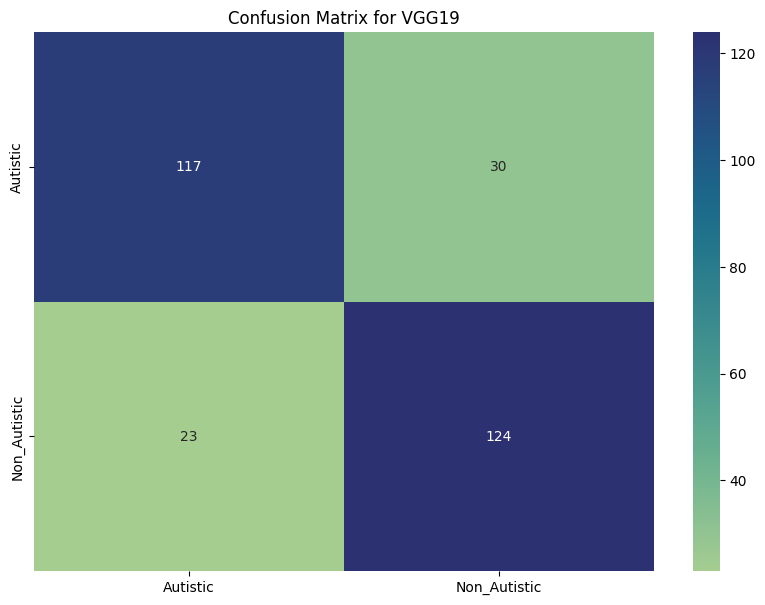

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60


W0000 00:00:1716400464.402721      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.4934 - loss: 1.1849

W0000 00:00:1716400516.119044      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


74/74 ━━━━━━━━━━━━━━━━━━━━ 119s 763ms/step - accuracy: 0.4939 - loss: 1.1832 - val_accuracy: 0.5034 - val_loss: 0.8189
Epoch 2/60
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - accuracy: 0.6518 - loss: 0.7556 - val_accuracy: 0.6361 - val_loss: 0.6477
Epoch 3/60
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 266ms/step - accuracy: 0.7165 - loss: 0.6178 - val_accuracy: 0.7041 - val_loss: 0.5876
Epoch 4/60
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - accuracy: 0.7808 - loss: 0.5302 - val_accuracy: 0.7211 - val_loss: 0.5738
Epoch 5/60
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - accuracy: 0.8178 - loss: 0.4325 - val_accuracy: 0.7653 - val_loss: 0.5506
Epoch 6/60
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - accuracy: 0.8388 - loss: 0.3641 - val_accuracy: 0.7619 - val_loss: 0.5572
Epoch 7/60
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - accuracy: 0.8895 - loss: 0.2759 - val_accuracy: 0.7755 - val_loss: 0.5571
Epoch 8/60
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 266ms/step - accuracy: 0.8954 - loss: 0.2542 - val_accuracy: 0.76

W0000 00:00:1716401697.664738      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 407ms/step
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       147
           1       0.78      0.78      0.78       147

   micro avg       0.78      0.78      0.78       294
   macro avg       0.78      0.78      0.78       294
weighted avg       0.78      0.78      0.78       294
 samples avg       0.78      0.78      0.78       294



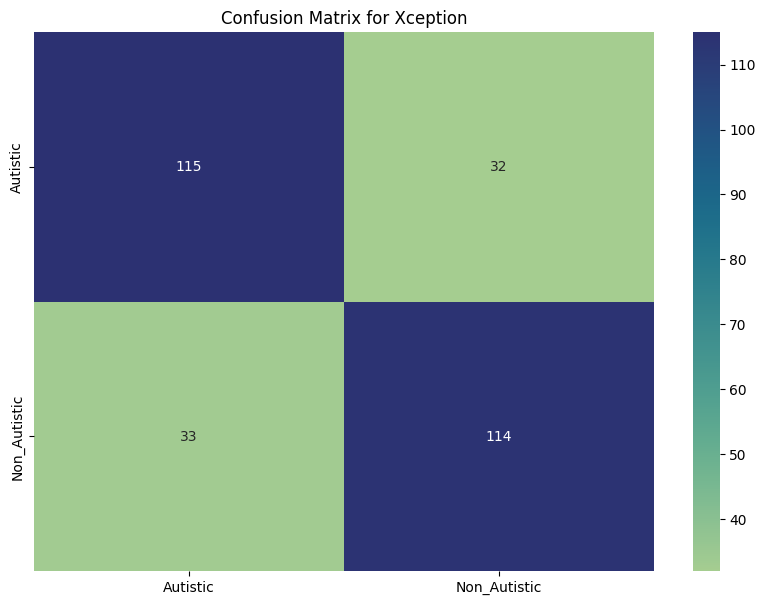

In [13]:
# Train and evaluate models
model_names = ['VGG19', 'Xception']

for model_name in model_names:
    model = create_model(model_name)
    train_and_evaluate_model(model, train_data, val_data, test_data, model_name)